# Tabular GANs performance study (Experiment 2)

This notebook contains the code to reproduce the performance study of copulaGAN.

In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import re
#from sdv.tabular import CopulaGAN, CTGAN,TVAE
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, ConfusionMatrixDisplay

In [2]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [3]:
df_alleles = pd.read_csv('oncoth1_with_n_risk_alleles.csv')

In [4]:
df = pd.read_csv('development_db_score_oncothromb.csv')

In [5]:
df_alleles['VTE'] = df['VTE'].values

# Apply paper preprocess pipeline

In [6]:
gen_predictors = ['rs4524', 'rs6025', 'rs2232698', 'rs2227631', 'rs268', 'rs169713', 'rs11696364', 'rs5110','rs6003']

In [7]:
#Select the risk alleles of the selected features
alleles_ = []
for element in gen_predictors:
    alleles_.append(element + '_n_risk_alleles')
alleles_.append('VTE')
alleles_.append('id')
df_alleles = df_alleles[alleles_].dropna()

### Compute Genetic Risk Score

In [8]:
from sklearn.linear_model import LogisticRegression

y = df_alleles['VTE']
X = df_alleles.drop(columns=['VTE', 'id'])

model = LogisticRegression(fit_intercept = True)
model.fit(X, y)

GRS = (model.coef_ * X).sum(axis=1) + model.intercept_
df_alleles['GRS'] = GRS

## Clinical Variables

- very high risk -> stomach, pancreas
- high risk -> lung, lymphoma, gynelocoligal, blader, testicular
- low risk -> colorectal
- platelet count >= 350x10^9/L -> high risk
- leukocyte count >= 11x10^9/L -> high risk

In [9]:
import re
def map_column(row, clinical_dict):
    row = str(row)
    for key, value in clinical_dict.items():
        if re.match(value[0], row):
            return key
    return 'No Clasificado'

In [10]:
def preprocess_clinical_features(df):
    df_clin = df.iloc[:, 1:21]
    cols_names_clin = df_clin.columns[1:]

    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Colorectal', 'primary_tumor_simplified'] = 0
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'NSCLC', 'primary_tumor_simplified'] = 1
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Oesophago-gastric', 'primary_tumor_simplified'] = 2
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Pancreatic', 'primary_tumor_simplified'] = 2

    df_clin.loc[df_clin['leukocytes'] < 11000, 'leukocytes'] = 0
    df_clin.loc[df_clin['leukocytes'] >= 11000, 'leukocytes'] = 1
    df_clin.loc[df_clin['platelets'] < 350000, 'platelets'] = 0
    df_clin.loc[df_clin['platelets'] >= 350000, 'platelets'] = 1

    bmi_risk = {
        1: [r"(Obese: BMI > 30 kg/m2)|( Overweight: BMI ~25-29.9 Kg/m2)"],
        0: [r"(Normal: BMI ~ 18.5-24.9 Kg/m2)|(Underweight: BMI < 18.5 Kg/m2)"],
    }

    tnm_stage_detailed_risk = {
        1: [r"(IA)|(IB)"],
        2: [r"(IIB)|(IIA)|(IIC)"],
        3: [r"(III)|(IIIB)|(IIIA)|(IIIC)"],
        4: [r"(IVB)|(IVA)|(IV)"],
    }


    df_clin['bmi_category'] = df_clin['bmi_category'].apply(lambda x: map_column(x, bmi_risk))
    df_clin['tnm_stage_detailed'] = df_clin['tnm_stage_detailed'].apply(lambda x: map_column(x, tnm_stage_detailed_risk))

    return df_clin

In [11]:
df_clin = preprocess_clinical_features(df)

### Get the clinical variables following the paper (without p-value selection )

In [12]:
# Drop the variables that are not mentioned in the paper
df_clin = df_clin.drop(['pregnancy', 'oral_contraceptives', 'hemoglobin'], axis=1)
df_clin['id'] = df['id'].values

Select the predictors of the paper

In [13]:
clin_predictors = ['tnm_stage_detailed', 'bmi_category', 'primary_tumor_simplified', 'id', 'VTE']
df_clin = df_clin[clin_predictors]
pred = ['id', 'GRS', 'VTE']
predictors = df_alleles[pred]
df_ft = predictors.merge(df_clin, on=['id','VTE'])
df = df_ft.drop(['id'],axis=1)
df['primary_tumor_simplified'] = df['primary_tumor_simplified'].astype(int)

In [14]:
df.head()

,GRS,VTE,tnm_stage_detailed,bmi_category,primary_tumor_simplified
0,-0.309952,1,4,1,2
1,-1.015882,0,2,0,2
2,-0.994715,0,3,1,2
3,-2.016533,0,2,0,2
4,-1.283673,0,1,0,2


Dataset with duplicates

In [15]:
X_real_dupes = df.drop('VTE', axis=1)
y_real_dupes = df['VTE']

Dataset with no duplicates

In [16]:
df_no_dupes = df.drop_duplicates()
X_real_no_dupes = df_no_dupes.drop('VTE', axis=1)
y_real_no_dupes = df_no_dupes['VTE']

# Generate Data

In [17]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CopulaGANSynthesizer

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


In [18]:
metadata_dict = metadata.to_dict()
metadata_obj = SingleTableMetadata.load_from_dict(metadata_dict)

In [19]:
metadata.update_column(
    column_name='VTE',
    sdtype='categorical')

metadata.update_column(
    column_name='tnm_stage_detailed',
    sdtype='categorical')

metadata.update_column(
    column_name='bmi_category',
    sdtype='categorical')

metadata.update_column(
    column_name='primary_tumor_simplified',
    sdtype='categorical')

In [20]:
metadata_dict = metadata.to_dict()
metadata_obj = SingleTableMetadata.load_from_dict(metadata_dict)

CopulaGAN

In [22]:
synthesizer = CopulaGANSynthesizer(metadata_obj, epochs=1000, batch_size=30, discriminator_steps=5, verbose=True)
synthesizer.fit(df)

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\numerical.py:112: UserWarning: No rounding scheme detected for column 'GRS'. Data will not be rounded.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_

Epoch 1, Loss G:  0.6765,Loss D: -0.1378
Epoch 2, Loss G:  0.4489,Loss D: -0.5566
Epoch 3, Loss G:  0.0789,Loss D: -0.0373
Epoch 4, Loss G: -0.0687,Loss D:  0.0592
Epoch 5, Loss G: -0.0036,Loss D:  0.1588
Epoch 6, Loss G: -0.1015,Loss D:  0.3144
Epoch 7, Loss G:  0.1661,Loss D:  0.0524
Epoch 8, Loss G:  0.0325,Loss D: -0.0569
Epoch 9, Loss G:  0.0742,Loss D: -0.3214
Epoch 10, Loss G: -0.4723,Loss D:  0.1134
Epoch 11, Loss G: -0.2012,Loss D:  0.0344
Epoch 12, Loss G: -0.4854,Loss D:  0.0309
Epoch 13, Loss G: -0.0431,Loss D: -0.2851
Epoch 14, Loss G: -0.1444,Loss D: -0.0930
Epoch 15, Loss G:  0.0371,Loss D: -0.2559
Epoch 16, Loss G:  0.0508,Loss D:  0.2237
Epoch 17, Loss G:  0.0756,Loss D: -0.0553
Epoch 18, Loss G:  0.3106,Loss D: -0.1771
Epoch 19, Loss G: -0.0083,Loss D: -0.1815
Epoch 20, Loss G:  0.4216,Loss D:  0.2599
Epoch 21, Loss G:  0.0863,Loss D:  0.0537
Epoch 22, Loss G: -0.0563,Loss D:  0.1031
Epoch 23, Loss G:  0.4872,Loss D: -0.2317
Epoch 24, Loss G:  0.2257,Loss D:  0.1755
E

Epoch 195, Loss G: -1.2010,Loss D:  0.2077
Epoch 196, Loss G: -0.8936,Loss D:  0.0869
Epoch 197, Loss G: -0.9059,Loss D: -0.1897
Epoch 198, Loss G: -1.1412,Loss D: -0.3960
Epoch 199, Loss G: -1.3198,Loss D:  0.3134
Epoch 200, Loss G: -0.7151,Loss D: -0.7591
Epoch 201, Loss G: -0.7714,Loss D: -0.7633
Epoch 202, Loss G: -0.6916,Loss D: -0.4203
Epoch 203, Loss G: -1.0914,Loss D:  0.0305
Epoch 204, Loss G: -1.2129,Loss D:  0.4056
Epoch 205, Loss G: -1.1400,Loss D:  0.2117
Epoch 206, Loss G: -0.4328,Loss D: -0.9590
Epoch 207, Loss G: -0.0761,Loss D: -0.2007
Epoch 208, Loss G: -0.2065,Loss D:  0.1140
Epoch 209, Loss G: -0.9448,Loss D: -0.2048
Epoch 210, Loss G: -0.5902,Loss D: -0.6513
Epoch 211, Loss G: -1.4934,Loss D: -0.0433
Epoch 212, Loss G: -1.4684,Loss D:  0.1774
Epoch 213, Loss G: -0.7101,Loss D:  0.3708
Epoch 214, Loss G: -1.5255,Loss D:  0.5067
Epoch 215, Loss G: -0.5656,Loss D:  0.4567
Epoch 216, Loss G: -0.9961,Loss D: -0.4615
Epoch 217, Loss G: -0.5363,Loss D:  1.2995
Epoch 218, 

Epoch 386, Loss G: -0.8172,Loss D:  0.5649
Epoch 387, Loss G: -0.0470,Loss D: -0.5932
Epoch 388, Loss G: -0.7090,Loss D:  0.2098
Epoch 389, Loss G: -0.0660,Loss D:  0.2760
Epoch 390, Loss G: -1.0461,Loss D:  0.3142
Epoch 391, Loss G: -0.1548,Loss D:  0.0524
Epoch 392, Loss G: -0.5286,Loss D: -0.4452
Epoch 393, Loss G: -0.8127,Loss D:  0.7328
Epoch 394, Loss G: -1.1318,Loss D:  0.2051
Epoch 395, Loss G: -0.2498,Loss D:  0.3257
Epoch 396, Loss G: -0.4596,Loss D: -0.3836
Epoch 397, Loss G: -1.3458,Loss D:  0.2049
Epoch 398, Loss G: -0.4863,Loss D: -0.3922
Epoch 399, Loss G: -1.2438,Loss D: -0.3038
Epoch 400, Loss G: -1.2344,Loss D:  1.1500
Epoch 401, Loss G: -0.3918,Loss D:  1.8845
Epoch 402, Loss G: -0.9010,Loss D: -0.5232
Epoch 403, Loss G: -0.6815,Loss D: -0.6610
Epoch 404, Loss G: -0.8643,Loss D:  0.3098
Epoch 405, Loss G:  0.1078,Loss D: -0.4516
Epoch 406, Loss G: -1.2256,Loss D: -0.4477
Epoch 407, Loss G: -0.7252,Loss D: -0.0345
Epoch 408, Loss G: -1.4740,Loss D:  1.1811
Epoch 409, 

Epoch 577, Loss G:  0.1055,Loss D:  0.1000
Epoch 578, Loss G: -0.9619,Loss D: -0.2615
Epoch 579, Loss G: -1.3491,Loss D: -0.8426
Epoch 580, Loss G: -0.7191,Loss D:  0.9922
Epoch 581, Loss G: -1.1652,Loss D: -0.4103
Epoch 582, Loss G: -0.5955,Loss D:  0.5805
Epoch 583, Loss G: -0.9096,Loss D:  0.4459
Epoch 584, Loss G:  0.0633,Loss D:  0.0517
Epoch 585, Loss G: -1.2612,Loss D: -0.0471
Epoch 586, Loss G: -1.1044,Loss D:  1.2751
Epoch 587, Loss G: -0.5819,Loss D: -1.1605
Epoch 588, Loss G: -0.6022,Loss D:  0.0584
Epoch 589, Loss G: -0.6567,Loss D: -0.1740
Epoch 590, Loss G: -1.8048,Loss D:  0.6922
Epoch 591, Loss G: -0.8799,Loss D: -0.0846
Epoch 592, Loss G: -0.9287,Loss D: -0.2295
Epoch 593, Loss G: -1.7577,Loss D: -0.1439
Epoch 594, Loss G:  0.3129,Loss D: -0.2492
Epoch 595, Loss G: -0.2920,Loss D: -1.0844
Epoch 596, Loss G: -1.2436,Loss D: -0.0030
Epoch 597, Loss G:  1.2984,Loss D: -0.0594
Epoch 598, Loss G:  0.1599,Loss D:  0.9166
Epoch 599, Loss G: -1.1397,Loss D:  0.3900
Epoch 600, 

Epoch 768, Loss G: -0.0480,Loss D: -0.4743
Epoch 769, Loss G: -1.2507,Loss D: -0.5675
Epoch 770, Loss G: -1.3622,Loss D: -0.3655
Epoch 771, Loss G: -0.6854,Loss D:  0.4362
Epoch 772, Loss G: -1.1468,Loss D:  0.4339
Epoch 773, Loss G: -0.5300,Loss D: -0.0834
Epoch 774, Loss G: -0.4307,Loss D:  0.4016
Epoch 775, Loss G: -0.9934,Loss D: -0.0713
Epoch 776, Loss G: -1.6145,Loss D:  1.2893
Epoch 777, Loss G: -1.5725,Loss D:  0.2184
Epoch 778, Loss G: -1.1302,Loss D: -0.8872
Epoch 779, Loss G: -1.0715,Loss D: -0.7383
Epoch 780, Loss G: -0.4392,Loss D: -0.9227
Epoch 781, Loss G: -1.5574,Loss D:  0.0375
Epoch 782, Loss G: -0.4329,Loss D: -0.0823
Epoch 783, Loss G: -1.5512,Loss D:  0.5825
Epoch 784, Loss G: -0.9561,Loss D: -0.1036
Epoch 785, Loss G: -0.9858,Loss D:  0.3059
Epoch 786, Loss G: -1.2883,Loss D:  0.7988
Epoch 787, Loss G: -0.6937,Loss D:  0.8223
Epoch 788, Loss G: -0.7224,Loss D:  0.0334
Epoch 789, Loss G: -1.1167,Loss D: -0.7641
Epoch 790, Loss G:  0.0326,Loss D: -0.5693
Epoch 791, 

Epoch 959, Loss G: -1.0629,Loss D: -0.7749
Epoch 960, Loss G: -0.8607,Loss D:  0.5320
Epoch 961, Loss G: -0.8377,Loss D:  0.4992
Epoch 962, Loss G: -1.1200,Loss D:  0.1637
Epoch 963, Loss G: -0.8973,Loss D:  0.4344
Epoch 964, Loss G: -0.6577,Loss D:  0.9125
Epoch 965, Loss G: -0.6669,Loss D:  0.1228
Epoch 966, Loss G: -0.7668,Loss D: -0.2553
Epoch 967, Loss G: -0.5598,Loss D: -0.0326
Epoch 968, Loss G: -1.0350,Loss D:  0.1335
Epoch 969, Loss G: -0.6863,Loss D:  0.9650
Epoch 970, Loss G: -0.9717,Loss D: -0.4484
Epoch 971, Loss G: -0.4011,Loss D:  0.2854
Epoch 972, Loss G: -1.3131,Loss D:  0.5809
Epoch 973, Loss G: -0.4584,Loss D: -0.5380
Epoch 974, Loss G: -1.8722,Loss D: -0.7642
Epoch 975, Loss G: -0.8329,Loss D: -0.1023
Epoch 976, Loss G: -1.5270,Loss D: -0.1376
Epoch 977, Loss G: -0.6108,Loss D:  0.4818
Epoch 978, Loss G: -1.5274,Loss D: -0.3879
Epoch 979, Loss G: -1.1177,Loss D: -0.4462
Epoch 980, Loss G: -1.4935,Loss D: -0.5302
Epoch 981, Loss G: -1.2286,Loss D: -0.6963
Epoch 982, 

Epoch 1147, Loss G: -0.8453,Loss D:  0.1060
Epoch 1148, Loss G: -1.3462,Loss D:  0.6627
Epoch 1149, Loss G: -0.4457,Loss D:  1.0239
Epoch 1150, Loss G: -0.9885,Loss D: -0.6759
Epoch 1151, Loss G: -0.5869,Loss D: -0.0429
Epoch 1152, Loss G: -0.7471,Loss D:  0.0362
Epoch 1153, Loss G: -0.2310,Loss D:  0.3325
Epoch 1154, Loss G: -0.1843,Loss D: -0.7372
Epoch 1155, Loss G: -0.5128,Loss D: -0.4905
Epoch 1156, Loss G: -0.8215,Loss D: -0.8430
Epoch 1157, Loss G: -0.4455,Loss D:  0.3813
Epoch 1158, Loss G: -1.0967,Loss D:  0.2518
Epoch 1159, Loss G: -0.7349,Loss D: -0.0173
Epoch 1160, Loss G:  0.1579,Loss D:  0.4748
Epoch 1161, Loss G: -0.7236,Loss D: -0.3723
Epoch 1162, Loss G: -0.8578,Loss D:  0.8500
Epoch 1163, Loss G: -1.1342,Loss D:  0.0156
Epoch 1164, Loss G: -0.7999,Loss D: -0.2717
Epoch 1165, Loss G: -0.9334,Loss D: -0.2657
Epoch 1166, Loss G: -0.8305,Loss D: -0.7963
Epoch 1167, Loss G: -2.3554,Loss D: -0.0154
Epoch 1168, Loss G: -0.7887,Loss D:  0.4433
Epoch 1169, Loss G: -1.3162,Loss

Epoch 1334, Loss G: -0.7632,Loss D:  0.0720
Epoch 1335, Loss G: -0.5130,Loss D: -0.4747
Epoch 1336, Loss G: -1.1283,Loss D:  0.5923
Epoch 1337, Loss G: -0.7725,Loss D:  0.4704
Epoch 1338, Loss G: -0.4966,Loss D: -0.1168
Epoch 1339, Loss G: -0.9377,Loss D:  0.1368
Epoch 1340, Loss G: -0.9318,Loss D: -0.0903
Epoch 1341, Loss G: -1.4760,Loss D: -0.0782
Epoch 1342, Loss G: -0.6401,Loss D: -0.7836
Epoch 1343, Loss G: -1.6935,Loss D: -0.0860
Epoch 1344, Loss G: -0.9016,Loss D:  0.1115
Epoch 1345, Loss G: -0.8384,Loss D:  0.0939
Epoch 1346, Loss G: -1.4798,Loss D: -0.4328
Epoch 1347, Loss G: -1.1037,Loss D: -0.6102
Epoch 1348, Loss G: -0.5341,Loss D:  0.3747
Epoch 1349, Loss G: -1.0684,Loss D: -1.0027
Epoch 1350, Loss G: -0.9413,Loss D: -1.1823
Epoch 1351, Loss G: -1.0487,Loss D: -0.4312
Epoch 1352, Loss G: -1.2085,Loss D:  1.5211
Epoch 1353, Loss G: -0.1009,Loss D: -0.8815
Epoch 1354, Loss G: -1.6619,Loss D:  0.4157
Epoch 1355, Loss G: -0.4631,Loss D: -0.8369
Epoch 1356, Loss G: -1.0673,Loss

Epoch 1521, Loss G: -1.4463,Loss D: -0.9644
Epoch 1522, Loss G: -2.0095,Loss D:  1.1725
Epoch 1523, Loss G: -0.7018,Loss D: -0.7464
Epoch 1524, Loss G: -0.6140,Loss D:  0.0575
Epoch 1525, Loss G: -1.1474,Loss D: -0.4604
Epoch 1526, Loss G: -0.9368,Loss D: -0.8249
Epoch 1527, Loss G: -1.2872,Loss D: -0.0082
Epoch 1528, Loss G: -0.6219,Loss D:  0.0423
Epoch 1529, Loss G: -0.8722,Loss D:  0.2081
Epoch 1530, Loss G: -0.6198,Loss D: -1.6119
Epoch 1531, Loss G: -0.1705,Loss D: -0.1716
Epoch 1532, Loss G: -0.8822,Loss D:  0.7287
Epoch 1533, Loss G: -0.5497,Loss D:  1.1746
Epoch 1534, Loss G: -0.6986,Loss D: -0.8605
Epoch 1535, Loss G: -0.4261,Loss D:  0.6533
Epoch 1536, Loss G: -0.8384,Loss D:  0.1550
Epoch 1537, Loss G: -0.8887,Loss D: -0.7075
Epoch 1538, Loss G: -0.4103,Loss D:  0.9159
Epoch 1539, Loss G: -0.2275,Loss D:  0.4391
Epoch 1540, Loss G: -1.1770,Loss D: -0.4113
Epoch 1541, Loss G: -0.4504,Loss D: -0.8263
Epoch 1542, Loss G: -1.0679,Loss D: -0.3295
Epoch 1543, Loss G: -0.6936,Loss

Epoch 1708, Loss G:  0.0091,Loss D: -0.6332
Epoch 1709, Loss G: -0.5073,Loss D: -1.0201
Epoch 1710, Loss G: -0.4928,Loss D:  0.2419
Epoch 1711, Loss G:  0.2999,Loss D:  0.8503
Epoch 1712, Loss G:  0.1763,Loss D: -0.4886
Epoch 1713, Loss G: -1.0697,Loss D: -0.2084
Epoch 1714, Loss G: -0.6221,Loss D:  0.0696
Epoch 1715, Loss G: -1.2701,Loss D: -0.5710
Epoch 1716, Loss G: -0.2862,Loss D: -0.2431
Epoch 1717, Loss G: -0.7966,Loss D: -0.1495
Epoch 1718, Loss G: -1.3954,Loss D: -0.3513
Epoch 1719, Loss G:  0.4226,Loss D: -0.4462
Epoch 1720, Loss G: -0.8741,Loss D: -0.2492
Epoch 1721, Loss G: -0.6435,Loss D:  1.1467
Epoch 1722, Loss G: -0.5502,Loss D: -0.1874
Epoch 1723, Loss G: -1.2008,Loss D: -0.0517
Epoch 1724, Loss G: -0.9033,Loss D:  0.6614
Epoch 1725, Loss G: -0.8087,Loss D: -1.6596
Epoch 1726, Loss G: -1.1961,Loss D: -0.4398
Epoch 1727, Loss G: -0.6554,Loss D:  0.5826
Epoch 1728, Loss G:  0.1598,Loss D: -0.2762
Epoch 1729, Loss G: -0.2407,Loss D: -0.5431
Epoch 1730, Loss G: -0.5429,Loss

Epoch 1895, Loss G: -0.3252,Loss D: -0.0236
Epoch 1896, Loss G: -1.5342,Loss D:  0.3295
Epoch 1897, Loss G: -0.2878,Loss D:  0.7222
Epoch 1898, Loss G: -1.7943,Loss D: -0.2186
Epoch 1899, Loss G: -1.7260,Loss D: -0.7685
Epoch 1900, Loss G: -1.2931,Loss D: -0.3627
Epoch 1901, Loss G: -1.2881,Loss D: -0.7495
Epoch 1902, Loss G: -1.9165,Loss D:  0.4656
Epoch 1903, Loss G: -1.2807,Loss D: -1.1805
Epoch 1904, Loss G: -0.4826,Loss D: -0.3563
Epoch 1905, Loss G: -0.9933,Loss D:  0.2996
Epoch 1906, Loss G: -1.1614,Loss D:  0.0204
Epoch 1907, Loss G: -1.3094,Loss D:  0.3961
Epoch 1908, Loss G: -0.2544,Loss D:  1.0014
Epoch 1909, Loss G: -1.2102,Loss D: -0.7872
Epoch 1910, Loss G: -1.2931,Loss D:  0.3709
Epoch 1911, Loss G: -0.4446,Loss D:  0.4190
Epoch 1912, Loss G: -1.4078,Loss D: -0.5445
Epoch 1913, Loss G: -1.0975,Loss D: -0.7722
Epoch 1914, Loss G: -0.9404,Loss D:  0.0331
Epoch 1915, Loss G: -1.4631,Loss D: -0.4765
Epoch 1916, Loss G: -1.2986,Loss D:  0.4980
Epoch 1917, Loss G: -0.6648,Loss

Save models

In [82]:
#synthesizer.save(filepath='test_CopulaGAN.pkl')

Load models

In [89]:
#synthesizer = CopulaGANSynthesizer.load(filepath='test_CopulaGAN.pkl')

Generate synthetic samples

In [28]:
synth_gen = synthesizer.sample(num_rows=150000)

# Evaluation

In [84]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(
    real_data=df_no_dupes,
    synthetic_data=synth_gen,
    metadata=metadata_obj)

Creating report: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.51it/s]



Overall Quality Score: 68.9%

Properties:
Column Shapes: 78.46%
Column Pair Trends: 59.34%


IPython not installed.


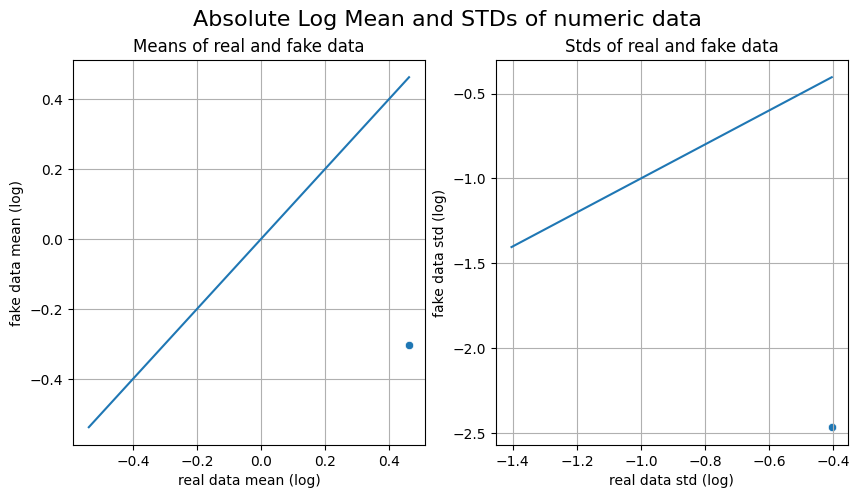

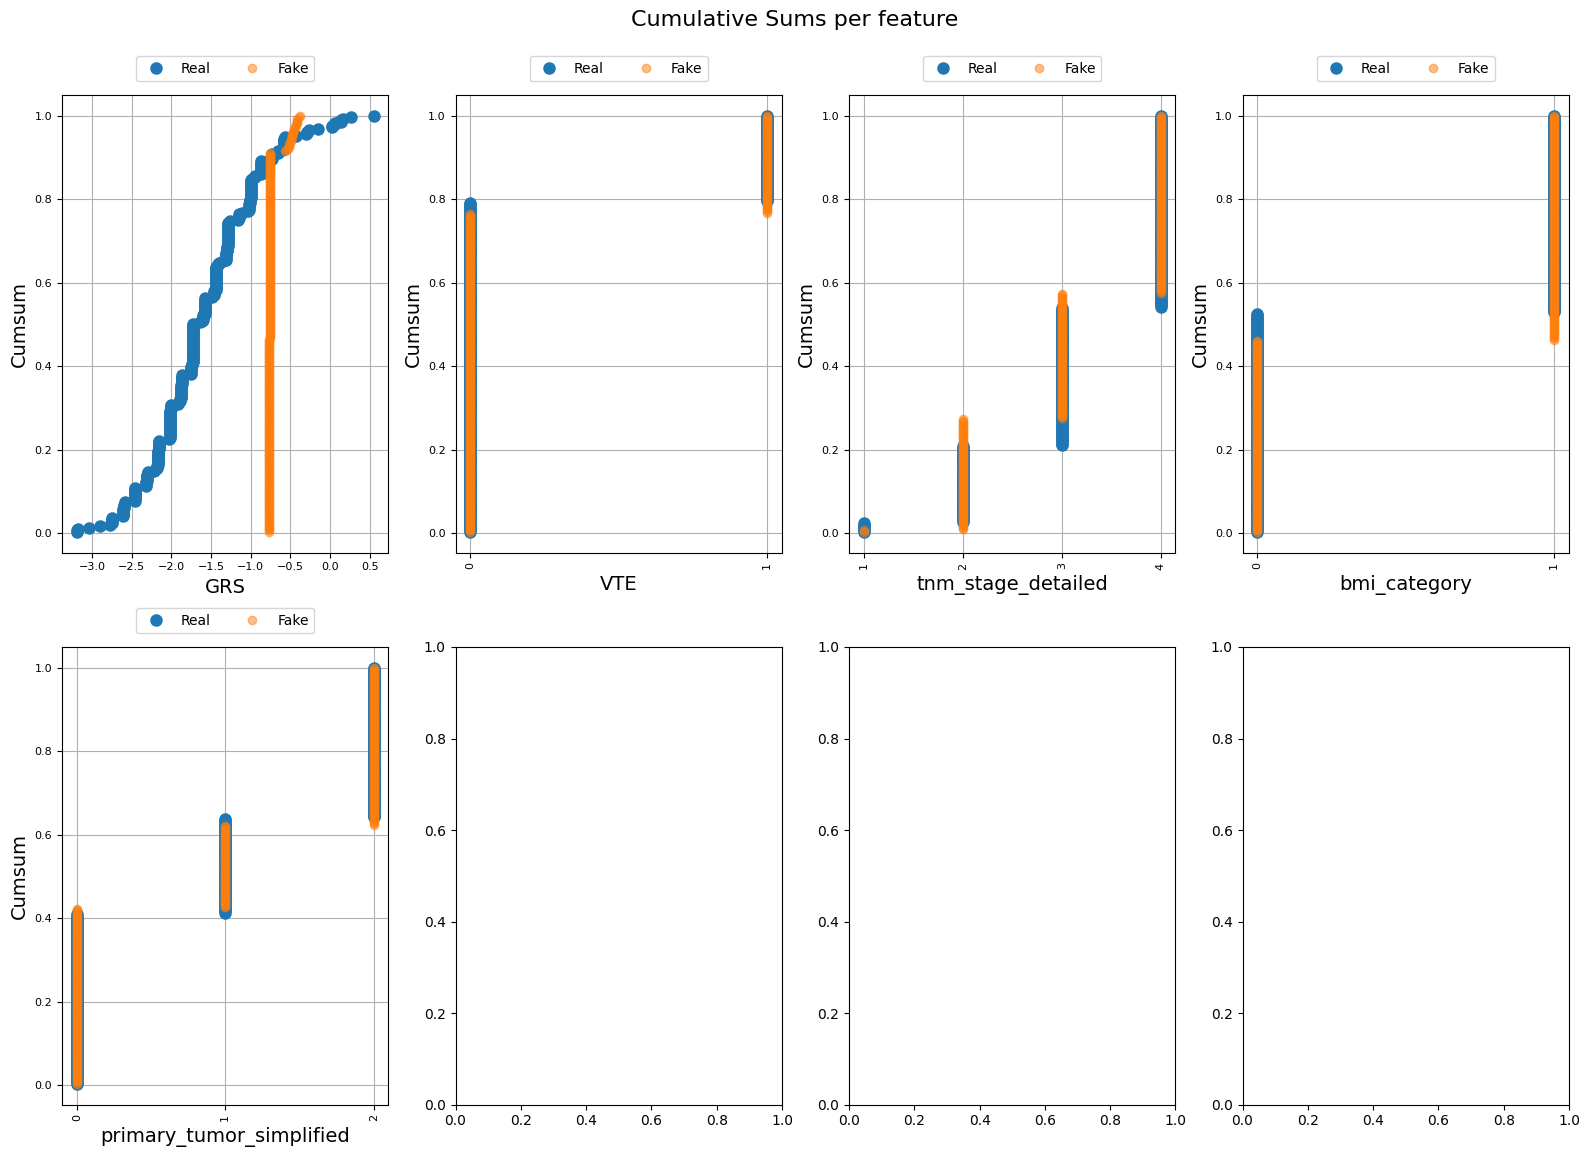

AttributeError: 'Series' object has no attribute 'append'

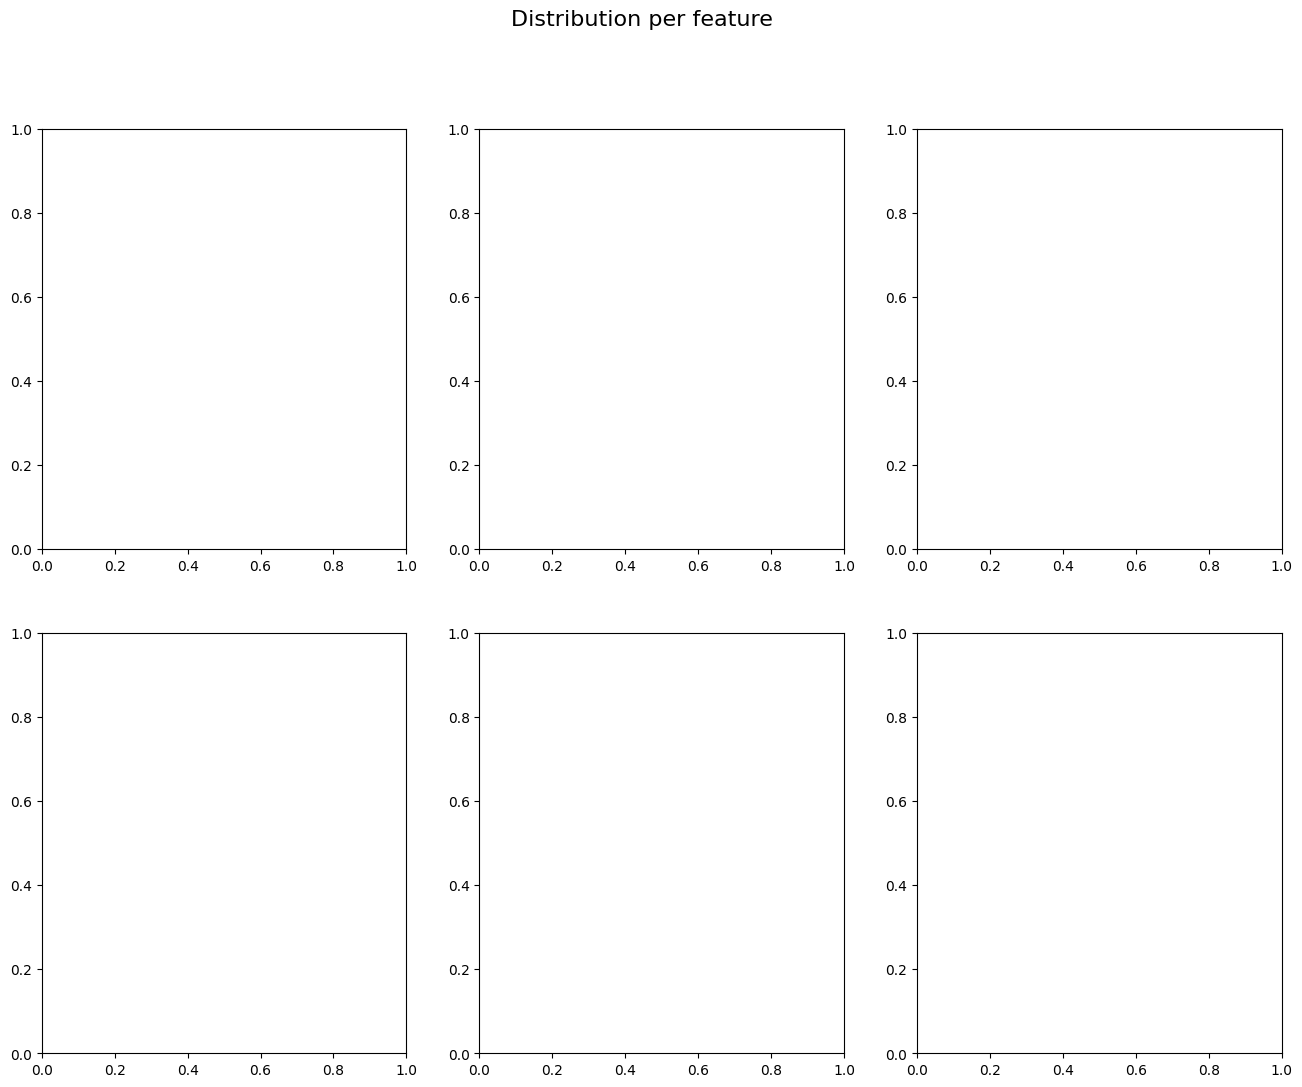

In [24]:
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(df_no_dupes, synth_gen, cat_cols = ['bmi_category', 'primary_tumor_simplified', 'VTE', 'tnm_stage_detailed'])
table_evaluator.visual_evaluation()

In [158]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synth_gen.drop('VTE', axis=1), synth_gen['VTE'], test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7994666666666667

In [155]:
y_pred = clf.predict(X_test)
auc_obs = roc_auc_score(y_test, y_pred)
print(auc_obs)

0.5440964665484043


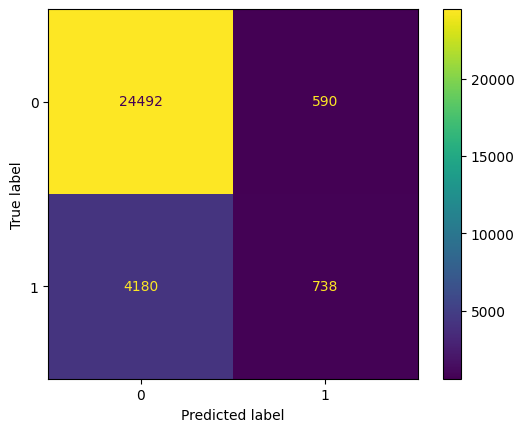

In [137]:
# Compute confusion matrix
cm = confusion_matrix(y_test.values, np.round(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [138]:
#Load data form baselines curves
roc_curve_onco = pd.read_csv('no_dups_roc_curve_oncothromb_score_replicated.csv')
pr_curve_onco = pd.read_csv('no_dups_pr_curve_oncothromb_score_replicated.csv')
roc_curve_orig = pd.read_csv('mean_roc_curve_from_cv_oncothromb.csv')
prc_curve_orig = pd.read_csv('pr_curve_oncothromb_score_replicated.csv')

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


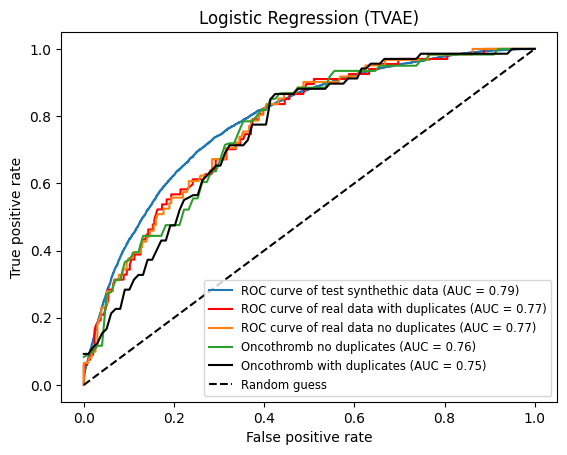

In [140]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
#fpr_2, tpr_2, thresholds_2 = roc_curve(y_points,pred_points)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_real_dupes,clf.predict_proba(X_real_dupes)[:,1])
fpr_4, tpr_4, thresholds_4 = roc_curve(y_real_no_dupes,clf.predict_proba(X_real_no_dupes)[:,1])


# Calculate the AUC value
auc_value = auc(fpr, tpr)
auc_value_2 = auc(fpr_3, tpr_3)
auc_value_5 = auc(fpr_4, tpr_4)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])


# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of test synthethic data (AUC = %0.2f)' % auc_value)
plt.plot(fpr_3, tpr_3, color='red',label='ROC curve of real data with duplicates (AUC = %0.2f)' % auc_value_2)
plt.plot(fpr_4, tpr_4,label='ROC curve of real data no duplicates (AUC = %0.2f)' % auc_value_5)
plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], label='Oncothromb no duplicates (AUC = %0.2f)' % auc_value_3)
plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'],color='black', label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression (TVAE)')
plt.legend(loc='lower right', fontsize='small')
# Save figure with higher DPI
plt.savefig('ROC_curve_TVAE_new.png', dpi=300)
plt.show()


C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


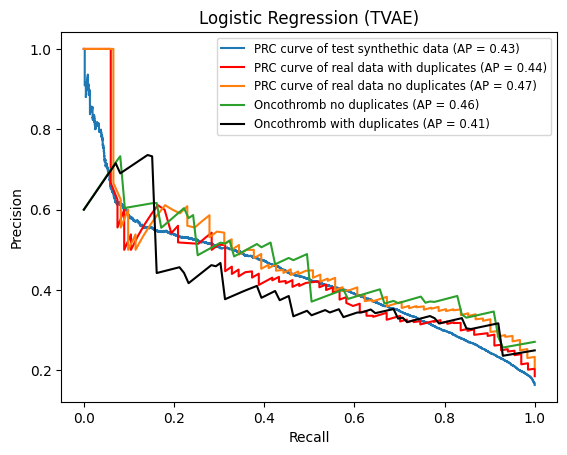

In [142]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision2, recall2, threshold2 = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

# Get precision, recall, and threshold values for real data
precision3, recall3, threshold3 = precision_recall_curve(y_real_dupes, clf.predict_proba(X_real_dupes)[:, 1])
precision4, recall4, threshold4 = precision_recall_curve(y_real_no_dupes, clf.predict_proba(X_real_no_dupes)[:, 1])


# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_2 = auc(recall2, precision2)
ap_3 = auc(recall3, precision3)
ap_5 = auc(recall4, precision4)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)


# Plot the test data Precision-Recall curve
ax.plot(recall2, precision2, label='PRC curve of test synthethic data (AP = %0.2f)' % ap_2)

# Plot the real data Precision-Recall curve
ax.plot(recall3, precision3, color='red', label='PRC curve of real data with duplicates (AP = %0.2f)' % ap_3)
ax.plot(recall4, precision4,  label='PRC curve of real data no duplicates (AP = %0.2f)' % ap_5)


# Plot the synthethic data Precision-Recall curve
ax.plot(pr_curve_onco.recall_points, pr_curve_onco.mean_precision, label='Oncothromb no duplicates (AP = %0.2f)' % ap)

ax.plot(prc_curve_orig.recall, prc_curve_orig.precision,color='black', label='Oncothromb with duplicates (AP = %0.2f)' % ap_4)

# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Logistic Regression (TVAE)")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
plt.savefig('PRC_curve_TVAE_new.png', dpi=300)
plt.show()


# Train a Deep Learning Model with Synthethic Data

In [58]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synth_gen.drop('VTE', axis=1), synth_gen['VTE'], test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def make_model(metrics=METRICS):

    # Define the MLP model with skip connections and dropout
    inputs = keras.layers.Input(shape=(X_train.shape[1],))
    
    x = keras.layers.Dense(units=128, activation='relu')(inputs)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(units=64, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    
   
    x = keras.layers.Dense(units=16, activation='relu')(x)
    
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model with the specified optimizer, loss function, and metrics
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss= keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics)

    return model

In [59]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=8,
    mode='max',
    restore_best_weights=True)

In [60]:
del model

In [61]:
from tensorflow.keras.optimizers.schedules import InverseTimeDecay

model = make_model(metrics=METRICS)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    epochs=EPOCHS,
    validation_data=(X_test, y_test))

Epoch 1/100
3750/3750 [==============================] - 13s 3ms/step - loss: 0.3683 - tp: 7917.0000 - fp: 4434.0000 - tn: 92558.0000 - fn: 15091.0000 - accuracy: 0.8373 - precision: 0.6410 - recall: 0.3441 - auc: 0.8329 - prc: 0.5537 - val_loss: 0.3625 - val_tp: 1940.0000 - val_fp: 956.0000 - val_tn: 23212.0000 - val_fn: 3892.0000 - val_accuracy: 0.8384 - val_precision: 0.6699 - val_recall: 0.3326 - val_auc: 0.8435 - val_prc: 0.5756
Epoch 2/100
3750/3750 [==============================] - 16s 4ms/step - loss: 0.3630 - tp: 7982.0000 - fp: 4277.0000 - tn: 92715.0000 - fn: 15026.0000 - accuracy: 0.8391 - precision: 0.6511 - recall: 0.3469 - auc: 0.8388 - prc: 0.5635 - val_loss: 0.3614 - val_tp: 2213.0000 - val_fp: 1203.0000 - val_tn: 22965.0000 - val_fn: 3619.0000 - val_accuracy: 0.8393 - val_precision: 0.6478 - val_recall: 0.3795 - val_auc: 0.8445 - val_prc: 0.5762
Epoch 3/100
3750/3750 [==============================] - 13s 4ms/step - loss: 0.3618 - tp: 7980.0000 - fp: 4262.0000 - tn: 

10/10 [==============================] - 0s 1ms/step


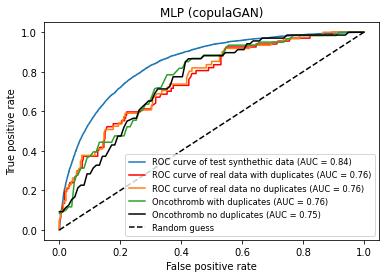

In [62]:
# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,model.predict(X_test))
fpr_3, tpr_3, thresholds_3 = roc_curve(y_real_dupes,model.predict(X_real_dupes))
fpr_4, tpr_4, thresholds_4 = roc_curve(y_real_no_dupes,model.predict(X_real_no_dupes))


# Calculate the AUC value
auc_value = auc(fpr, tpr)
auc_value_2 = auc(fpr_3, tpr_3)
auc_value_5 = auc(fpr_4, tpr_4)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])


# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of test synthethic data (AUC = %0.2f)' % auc_value)
plt.plot(fpr_3, tpr_3,color='red', label='ROC curve of real data with duplicates (AUC = %0.2f)' % auc_value_2)
plt.plot(fpr_4, tpr_4, label='ROC curve of real data no duplicates (AUC = %0.2f)' % auc_value_5)

plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_3)
plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'], color='black',label='Oncothromb no duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('MLP (copulaGAN)')
plt.legend(loc='best', fontsize='small')

# Save figure with higher DPI
plt.savefig('ROC_curve_MLP_copulaGAN.png', dpi=300)
plt.show()

10/10 [==============================] - 0s 1ms/step


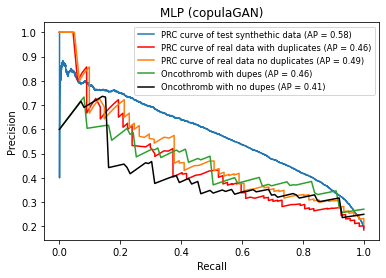

In [63]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision2, recall2, threshold2 = precision_recall_curve(y_test, model.predict(X_test))

# Get precision, recall, and threshold values for real data
precision3, recall3, threshold3 = precision_recall_curve(y_real_dupes, model.predict(X_real_dupes))
precision4, recall4, threshold4 = precision_recall_curve(y_real_no_dupes, model.predict(X_real_no_dupes))


# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)
ap_2 = auc(recall2, precision2)
ap_3 = auc(recall3, precision3)
ap_5 = auc(recall4, precision4)

# Plot the test data Precision-Recall curve
ax.plot(recall2, precision2, label='PRC curve of test synthethic data (AP = %0.2f)' % ap_2)

# Plot the real data Precision-Recall curve
ax.plot(recall3, precision3, color='red', label='PRC curve of real data with duplicates (AP = %0.2f)' % ap_3)
ax.plot(recall4, precision4, label='PRC curve of real data no duplicates (AP = %0.2f)' % ap_5)


# Plot the synthethic data Precision-Recall curve
ax.plot(pr_curve_onco.recall_points, pr_curve_onco.mean_precision, label='Oncothromb with dupes (AP = %0.2f)' % ap)

ax.plot(prc_curve_orig.recall, prc_curve_orig.precision,color='black', label='Oncothromb with no dupes (AP = %0.2f)' % ap_4)


# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("MLP (copulaGAN)")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
plt.savefig('PRC_curve_MLP_copulaGAN.png', dpi=300)
plt.show()